**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
##  Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

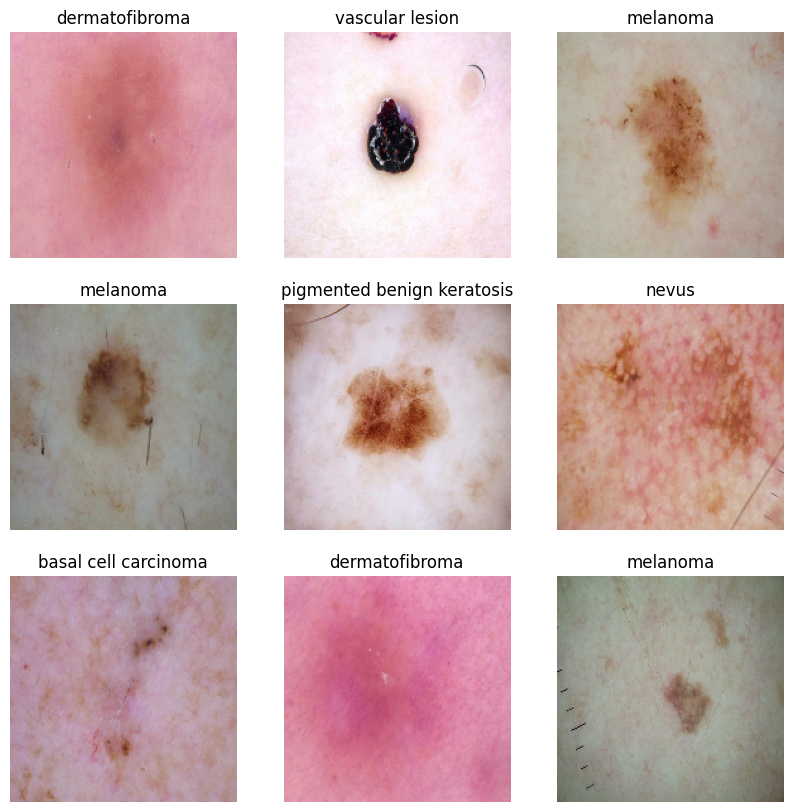

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.2452 - loss: 1.9951 - val_accuracy: 0.4232 - val_loss: 1.5732
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4571 - loss: 1.4213 - val_accuracy: 0.5011 - val_loss: 1.3425
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5544 - loss: 1.1934 - val_accuracy: 0.5976 - val_loss: 1.1335
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6105 - loss: 1.0376 - val_accuracy: 0.6058 - val_loss: 1.0942
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6815 - loss: 0.8730 - val_accuracy: 0.6860 - val_loss: 0.8545
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7742 - loss: 0.6496 - val_accuracy: 0.7068 - val_loss: 0.8025
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8161 - loss: 0.5213 - val_accuracy: 0.7565 - val_loss: 0.7783
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8595 - loss: 0.4043 - val_accu

### Visualizing training results

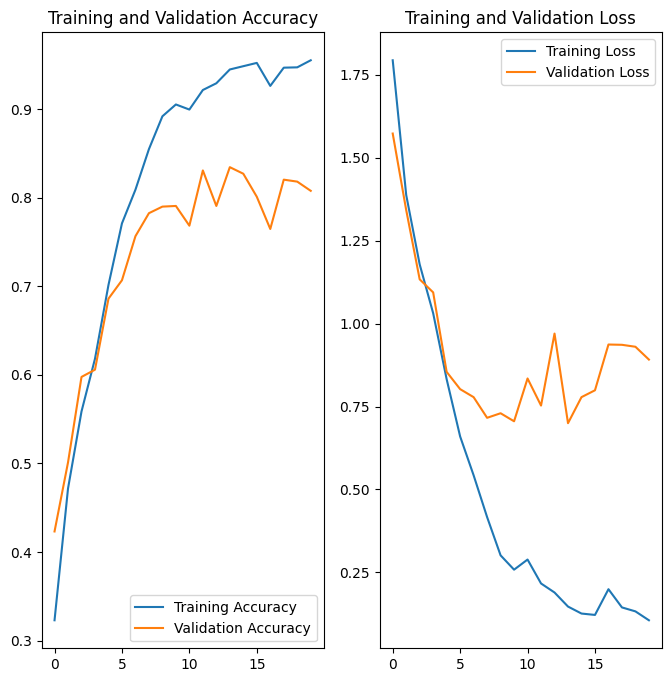

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

*   The Model Training Accuracy shows accuracy of 96% while the validation accuracy is of 80% having some  gap between these two's.
*   A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

*   These Observations confirms there is **overfitting** between the training data nad validation data, to overcome overfitting we will be applying some agumentation techniques with the current dataset.






In [19]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here


augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])



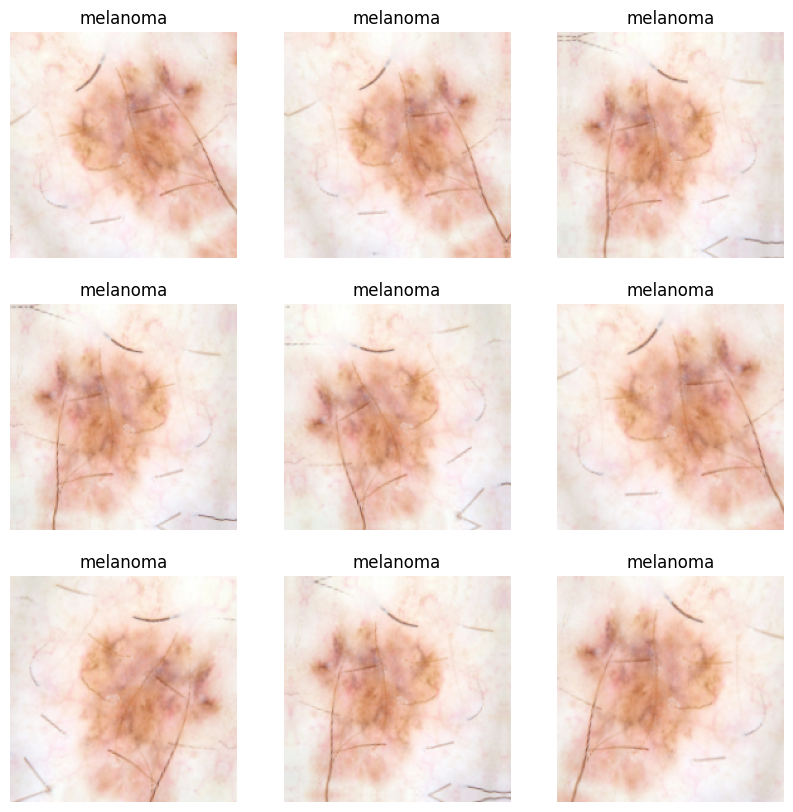

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")


### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compiling the model

In [22]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.1983 - loss: 2.1048 - val_accuracy: 0.3252 - val_loss: 1.7260
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3717 - loss: 1.6136 - val_accuracy: 0.4209 - val_loss: 1.4910
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4299 - loss: 1.4646 - val_accuracy: 0.4863 - val_loss: 1.3908
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4741 - loss: 1.3683 - val_accuracy: 0.4781 - val_loss: 1.3945
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4683 - loss: 1.3821 - val_accuracy: 0.5264 - val_loss: 1.2724
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5312 - loss: 1.2332 - val_accuracy: 0.5397 - val_loss: 1.2006
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5429 - loss: 1.2100 - val_accuracy: 0.5813 - val_loss: 1.1036
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5496 - loss: 1.1562 - val_acc

### Visualizing the results

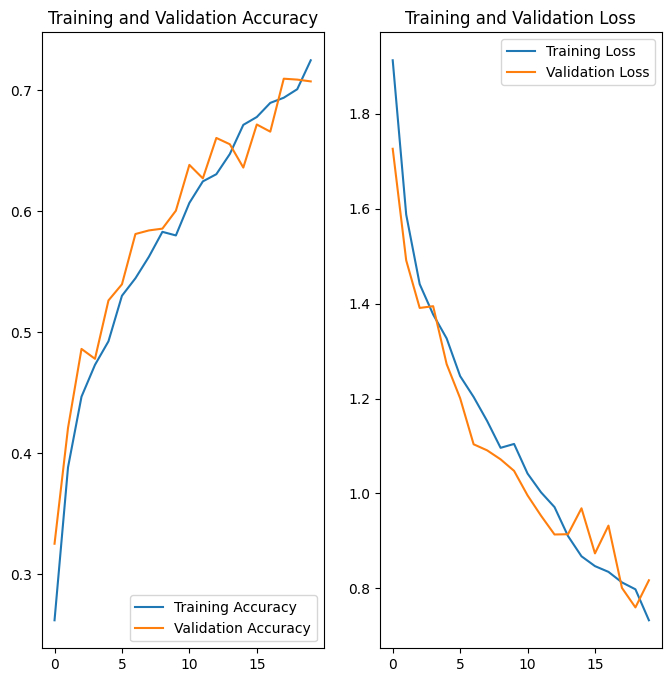

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observations:**

1. After applying agumentation the overfitting has been decreased signifgantly between train and validation data such as 72% and 70%.

2. Though the acuuracy value has been decreased compared to the previous model without agumentation, but the overfitting issue has been addressed and have been reduced signifigantly.

3. There is lot of room for impoving the accuracy and perfomance for both train and validation data.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [26]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010872.jpg', 'seborrheic keratosis'), ('/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010923.jpg', 'seborrheic keratosis'), ('/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010890.jpg', 'seborrheic keratosis'), ('/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010898.jpg', 'seborrheic keratosis'), ('/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010912.jpg', 'seborrheic keratosis')]


In [27]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis
1,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis
2,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis
3,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis
4,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis


In [28]:
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


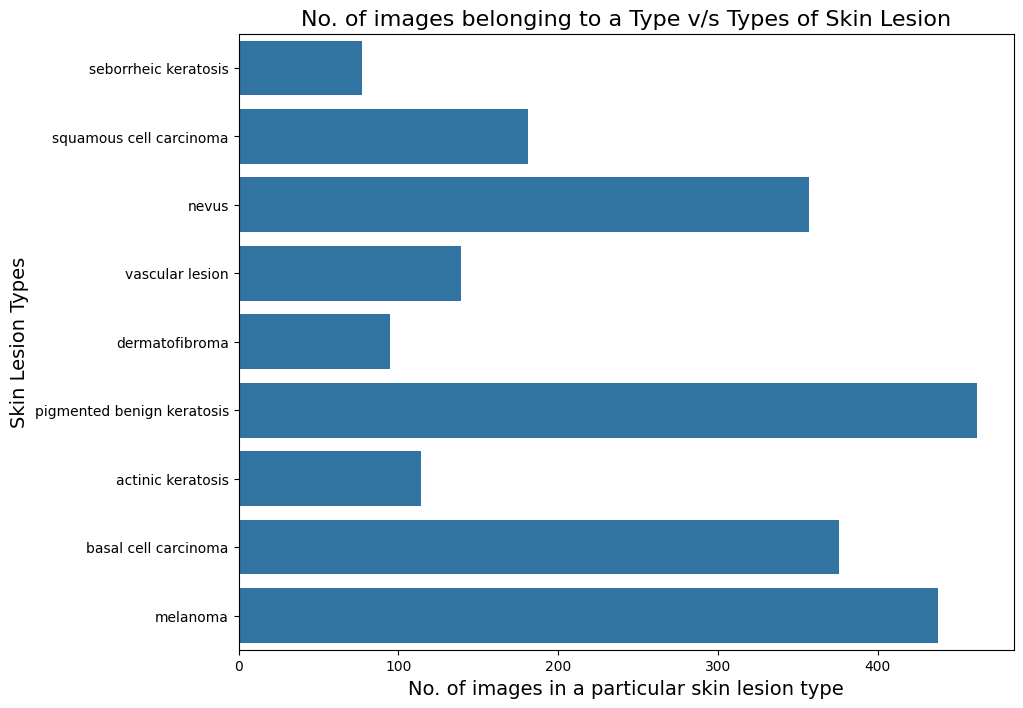

In [29]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [30]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


####  Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


**Observations regarding class Imbalance:**

---

1.   Class Imbalance is definetly present in the training data set.
2.   "seborrheic keratosis" has least percentage of classification data with 3.44 %
3."pigmented benign keratosis" & "melanoma" has the highest no of classes with almost 20%.





####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CB0B6514790>: 100%|██████████| 500/500 [00:23<00:00, 21.73 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CB0AA65B550>: 100%|██████████| 500/500 [00:26<00:00, 19.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CB0B62D98D0>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x545 at 0x7CB0B6219710>: 100%|██████████| 500/500 [01:42<00:00,  4.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CB0B63C8FD0>: 100%|██████████| 500/500 [01:19<00:00,  6.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB0B6116FD0>: 100%|██████████| 500/500 [00:18<00:00, 26.41 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7CB0AA65E1D0>: 100%|██████████| 500/500 [00:41<00:00, 11.98 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB0B623E390>: 100%|██████████| 500/500 [00:19<00:00, 25.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CB0B621C590>: 100%|██████████| 500/500 [00:20<00:00, 24.92 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_670bb8f6-543b-46f3-b199-ae4c36a1df81.jpg',
 '/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011140.jpg_83aee82e-1b49-4363-9e12-1e20dbf7ea64.jpg',
 '/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_0af85ea0-7fbb-4c22-9527-4d348f573ff6.jpg',
 '/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_413ba2d7-5953-4c9c-baf5-796a0d4384e6.jpg',
 '/content/drive/My Drive/MyData/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ou

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
lesions_df.head()

,Image Path,Label
0,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis
1,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis
2,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis
3,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis
4,/content/drive/My Drive/MyData/Skin cancer ISI...,seborrheic keratosis


In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([lesions_df, df2])

In [40]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,1462
melanoma,1438
basal cell carcinoma,1376
nevus,1357
squamous cell carcinoma,1181
vascular lesion,1139
actinic keratosis,1114
dermatofibroma,1095
seborrheic keratosis,1077


In [41]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,13.01
melanoma,12.79
basal cell carcinoma,12.24
nevus,12.07
squamous cell carcinoma,10.51
vascular lesion,10.13
actinic keratosis,9.91
dermatofibroma,9.74
seborrheic keratosis,9.58


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [43]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


####  Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


####Create your model (make sure to include normalization)

In [45]:

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

####  Compile your model (Choose optimizer and loss function appropriately)

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [47]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 79s 266ms/step - accuracy: 0.2839 - loss: 2.9761 - val_accuracy: 0.1811 - val_loss: 12.3028
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 263ms/step - accuracy: 0.4466 - loss: 1.4441 - val_accuracy: 0.4290 - val_loss: 1.6611
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 63s 225ms/step - accuracy: 0.5056 - loss: 1.2951 - val_accuracy: 0.5309 - val_loss: 1.2391
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 217ms/step - accuracy: 0.5258 - loss: 1.2035 - val_accuracy: 0.4909 - val_loss: 1.3445
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 92s 255ms/step - accuracy: 0.5638 - loss: 1.0920 - val_accuracy: 0.4700 - val_loss: 1.5227
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 64s 228ms/step - accuracy: 0.5860 - loss: 1.0625 - val_accuracy: 0.5496 - val_loss: 1.1452
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 88s 250ms/step - accuracy: 0.6030 - loss: 1.0100 - val_accuracy: 0.4762 - val_loss: 1.6258
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - accuracy: 0.6222 - loss: 

####   Visualize the model results

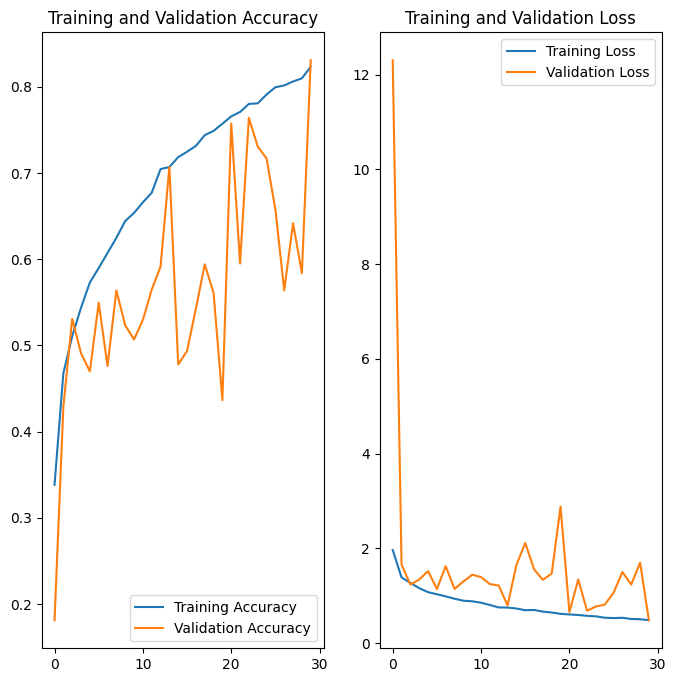

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Observations:**

*  After doing class imbalance , we got the final accuracy of 81% and 83 % but the accuracy graph does not seems to be doing that great.
* Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.



**Creating another model (without batch normalization)**

In [50]:
# create the model
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

**Compiling the Model**

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

**Fitting the Model**

In [52]:
%%time
# train the model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2354 - loss: 1.9831
Epoch 1: val_accuracy improved from -inf to 0.47753, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 66s 225ms/step - accuracy: 0.2358 - loss: 1.9823 - val_accuracy: 0.4775 - val_loss: 1.4007
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4545 - loss: 1.4192
Epoch 2: val_accuracy improved from 0.47753 to 0.53138, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 92s 260ms/step - accuracy: 0.4545 - loss: 1.4191 - val_accuracy: 0.5314 - val_loss: 1.2313
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5028 - loss: 1.2768
Epoch 3: val_accuracy improved from 0.53138 to 0.58700, saving model to model.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 79s 250ms/step - accuracy: 0.5029 - loss: 1.2767 - val_accuracy: 0.5870 - val_loss: 1.1254
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5564 - loss: 1.1502
Epoch 4: val_accuracy improved from 0.5

**Final Observations:**

1. After running the model with removal of Batch Normalization and adding early stop with epochs set to 50, we get a solid Accuray of 85% and Validation Accuracy of 82% which is reasonably Good & we got this accuracy early in Epochs "25" itself.

2. We have got rid of both underfitting and overfitting compared to our earlier models with help of augmentation and use of Dropouts.

3. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

4. The addition of batch normalization failed to enhance both training and validation accuracy.


**Final Model Evaluation**




In [61]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

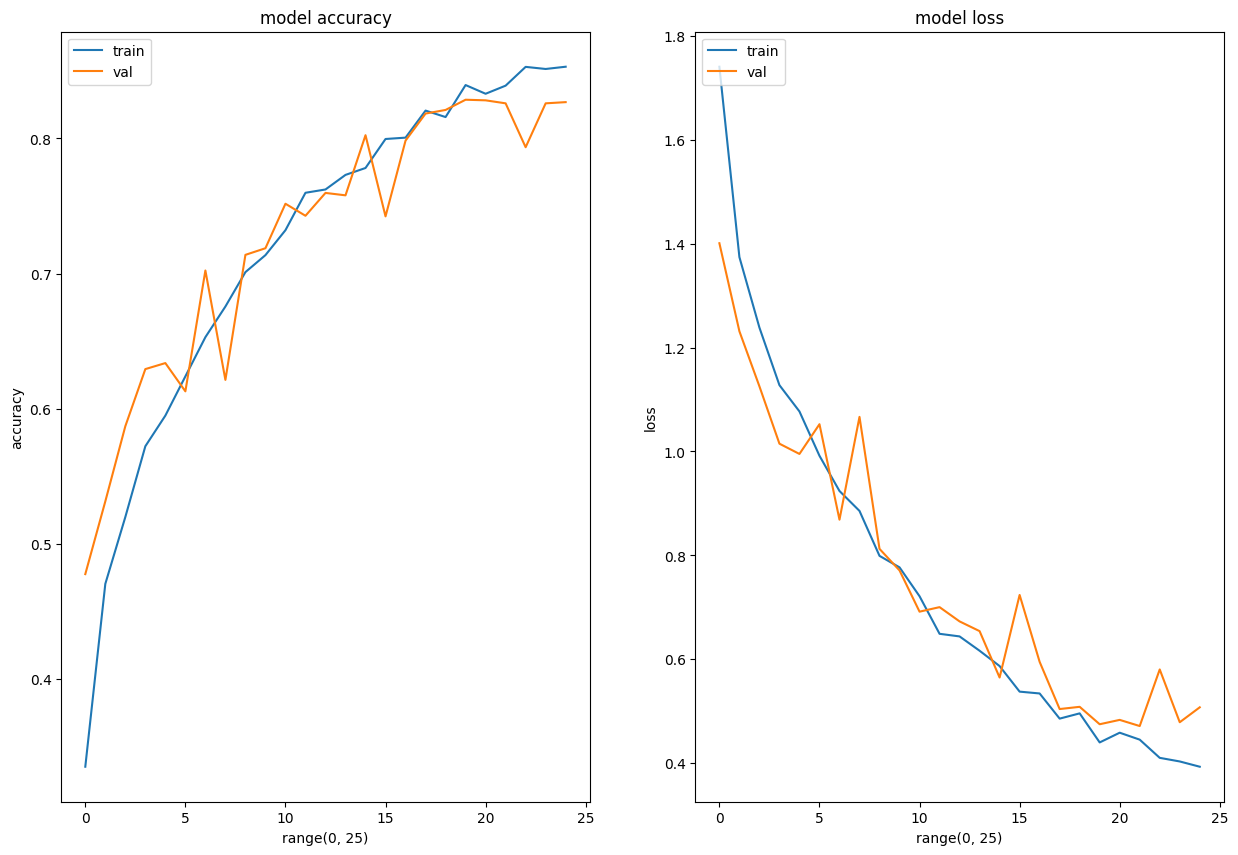

In [62]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Final Model Prediciton:**

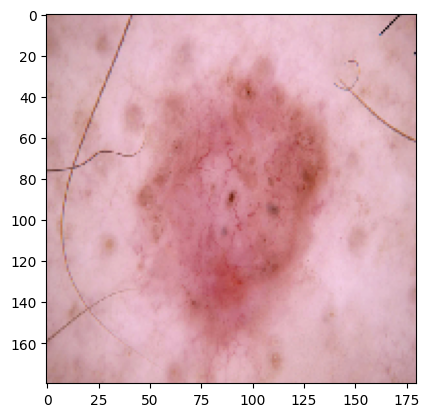

In [79]:
from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)

test_image = load_img(test_image[0], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

In [80]:
img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [81]:
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)

Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


##################### END OF NOTEBOOK ########################################